# Influence of DFG conformation on structure distances

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opencadd.databases.klifs import setup_local

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/20210324/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_local(HERE / "../../data/external/20210114_KLIFS_HUMAN/")
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = (
    DATA / "fingerprint_distances_41-41-41-41-41-41-41-41-83-83-83-83-111-111-111.json"
)

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_json(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 293
Number of structures: 4918


In [11]:
structure_distances = fingerprint_distance_generator.data

### Remove unwanted structures

In [12]:
# Remove code after when using latest data
structure_distances = structure_distances[
    ~structure_distances.apply(
        lambda x: (x["structure1"] in [59, 7083]) or (x["structure2"] in [59, 7083]), axis=1
    )
]

### Sort fingerprint/kinase pairs (alphabetically)

In [14]:
# Takes 2 minutes
%%time

structure_distances["structure_pair"] = (
    structure_distances[["structure1", "structure2"]].apply(list, axis=1).apply(sorted)
)
structure_distances["kinase_pair"] = (
    structure_distances[["kinase1", "kinase2"]].apply(list, axis=1).apply(sorted)
)

structure_distances["structure1"] = [i[0] for i in structure_distances["structure_pair"]]
structure_distances["structure2"] = [i[1] for i in structure_distances["structure_pair"]]
structure_distances["kinase1"] = [i[0] for i in structure_distances["kinase_pair"]]
structure_distances["kinase2"] = [i[1] for i in structure_distances["kinase_pair"]]
structure_distances = structure_distances.drop(["structure_pair", "kinase_pair"], axis=1)
structure_distances.head()

CPU times: user 1min 13s, sys: 1.34 s, total: 1min 15s
Wall time: 1min 15s
CPU times: user 1min 8s, sys: 1.09 s, total: 1min 9s
Wall time: 1min 9s


,structure1,structure2,kinase1,kinase2,distance,coverage
0,3835,6679,AAK1,AAK1,0.053726,0.995417
1,3835,7156,AAK1,AAK1,0.066557,0.994583
2,1104,3835,AAK1,ABL1,0.251198,0.994167
3,1065,3835,AAK1,ABL1,0.264613,0.994167
4,1090,3835,AAK1,ABL1,0.233935,0.994167


### Filter distances by coverage cutoff

In [15]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure1,structure2,kinase1,kinase2,distance,coverage,distance_filtered
0,3835,6679,AAK1,AAK1,0.053726,0.995417,0.053726
1,3835,7156,AAK1,AAK1,0.066557,0.994583,0.066557
2,1104,3835,AAK1,ABL1,0.251198,0.994167,0.251198
3,1065,3835,AAK1,ABL1,0.264613,0.994167,0.264613
4,1090,3835,AAK1,ABL1,0.233935,0.994167,0.233935


In [16]:
print(f"Structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[structure_distances["distance_filtered"].notna()]
print(f"Structure pairs not-NaN: {structure_distances.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11851916


## DFG conformation

### Plot DFG-in vs. DFG-out

In [17]:
%%time

dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg1"] = structure_distances["structure1"].apply(lambda x: dfg[x])
structure_distances["dfg2"] = structure_distances["structure2"].apply(lambda x: dfg[x])

CPU times: user 29.4 s, sys: 216 ms, total: 29.6 s
Wall time: 29.6 s
CPU times: user 29 s, sys: 208 ms, total: 29.2 s
Wall time: 29.2 s


In [18]:
structure_distances.head()

,structure1,structure2,kinase1,kinase2,distance,coverage,distance_filtered,dfg1,dfg2
0,3835,6679,AAK1,AAK1,0.053726,0.995417,0.053726,in,in
1,3835,7156,AAK1,AAK1,0.066557,0.994583,0.066557,in,in
2,1104,3835,AAK1,ABL1,0.251198,0.994167,0.251198,out-like,in
3,1065,3835,AAK1,ABL1,0.264613,0.994167,0.264613,out,in
4,1090,3835,AAK1,ABL1,0.233935,0.994167,0.233935,in,in


In [30]:
structure_distances[(structure_distances["dfg1"] == "in") & (structure_distances["dfg2"] == "in")][
    "distance_filtered"
].notna()

0           True
1           True
4           True
6           True
9           True
            ... 
12090898    True
12090899    True
12090900    True
12090901    True
12090902    True
Name: distance_filtered, Length: 8904825, dtype: bool

In [48]:
structure_distances_dfg = {
    "all": structure_distances["distance_filtered"],
    "in/in": structure_distances[
        (structure_distances["dfg1"] == "in") & (structure_distances["dfg2"] == "in")
    ]["distance_filtered"],
    "out/out": structure_distances[
        (structure_distances["dfg1"] == "out") & (structure_distances["dfg2"] == "out")
    ]["distance_filtered"],
    "in/out": structure_distances[
        ((structure_distances["dfg1"] == "in") & (structure_distances["dfg2"] == "out"))
        | ((structure_distances["dfg1"] == "out") & (structure_distances["dfg2"] == "in"))
    ]["distance_filtered"],
}
structure_distances_dfg = pd.DataFrame(structure_distances_dfg)

In [49]:
structure_distances_dfg.notna().sum()

all        11851916
in/in       8904825
out/out       79401
in/out      1683225
dtype: int64

In [50]:
structure_distances_dfg.describe()

,all,in/in,out/out,in/out
count,1.185192e+07,8.904825e+06,79401.000000,1.683225e+06
mean,2.370296e-01,2.337824e-01,0.217745,2.409129e-01
std,7.170763e-02,7.177577e-02,0.072763,6.442875e-02
min,0.000000e+00,0.000000e+00,0.000000,1.553719e-02
25%,1.927443e-01,1.898313e-01,0.173344,1.995625e-01
50%,2.229435e-01,2.202187e-01,0.212018,2.271131e-01
75%,2.654165e-01,2.617071e-01,0.251953,2.685352e-01
max,7.574618e-01,7.444462e-01,0.606648,7.556599e-01


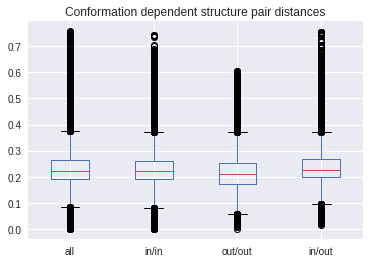

In [51]:
structure_distances_dfg.plot(kind="box", title="Conformation dependent structure pair distances");